### Conditions description:
<ul>
    <li>C1 = low interference, easy search -> 'SearchDomain' diff, 'SearchLevel' easy</li>
    <li>C2 = low interference, hard search -> 'SearchDomain' diff, 'SearchLevel' hard</li>
    <li>C3 = high interference, easy search -> 'SearchDomain' same, 'SearchLevel' easy</li>
    <li>C4 = high interference, hard search -> 'SearchDomain' same, 'SearchLevel' hard</li>
</ul>

Questions/Notes: 


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
import nilearn
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from nilearn.plotting import plot_design_matrix
from nilearn.image import concat_imgs, mean_img, resample_img
from nilearn.glm.thresholding import threshold_stats_img
from nilearn import plotting
from bids import BIDSLayout, BIDSValidator

/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load fMRI data

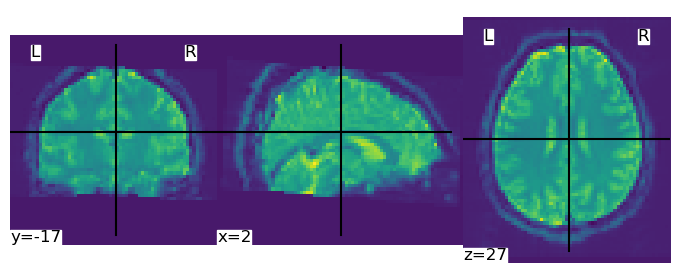

In [2]:
# First run data
img = nib.load("DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz")
path = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
fmri_img = concat_imgs(path)

# Obtain mean image from first participant fmri session
# 'mean_img' will be useful to set a background to plot contrasts against it
mean_img = mean_img(fmri_img)
plotting.plot_img(mean_img)
plt.show()

# Read scanning info from file 
# Important, get 'tr' information
#header = img.header
#print(header.get_zooms()) # tr=2
tr = 2
#print(header)

## Load the 8 runs fmri data

In [3]:
path1 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path2 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path3 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path4 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-04_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path5 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-05_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path6 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-06_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path7 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-07_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path8 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-08_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"

fmri_img = [concat_imgs(path1, auto_resample=True),
            concat_imgs(path2, auto_resample=True),
            concat_imgs(path3, auto_resample=True),
            concat_imgs(path4, auto_resample=True),
            concat_imgs(path5, auto_resample=True),
            concat_imgs(path6, auto_resample=True),
            concat_imgs(path7, auto_resample=True),
            concat_imgs(path8, auto_resample=True)]
           
affine, shape = fmri_img[0].affine, fmri_img[0].shape


# Resampling images to fit same affine
# Though, I think they already have the same affine
fmri_img[1] = resample_img(fmri_img[1], affine, shape[:3])
fmri_img[2] = resample_img(fmri_img[2], affine, shape[:3])
fmri_img[3] = resample_img(fmri_img[3], affine, shape[:3])
fmri_img[4] = resample_img(fmri_img[4], affine, shape[:3])
fmri_img[5] = resample_img(fmri_img[5], affine, shape[:3])
fmri_img[6] = resample_img(fmri_img[6], affine, shape[:3])
fmri_img[7] = resample_img(fmri_img[7], affine, shape[:3])
print('Resampling done.')
print("Total fmri data files: " + str(len(fmri_img)))

Resampling done.
Total fmri data files: 8


In [4]:
fmri_img4C1 = [fmri_img[0], fmri_img[1], fmri_img[3], fmri_img[4], fmri_img[5], fmri_img[6], fmri_img[7]]

## Load events (task/behavioral data)

In [5]:
#df[['memitem1', 'targstim', 'probe']].head(25)

# Create empty DataFrame (one per run)
#events_cue1 = pd.DataFrame()
#events2 = pd.DataFrame()
#events3 = pd.DataFrame()
#events4 = pd.DataFrame()
#events5 = pd.DataFrame()
#events6 = pd.DataFrame()
#events7 = pd.DataFrame()
#events8 = pd.DataFrame()
#total_events = [events1, events2, events3, events4, events5, events6, events7, events8]

In [6]:
# Path to behavioral data file
e_path1 = "DistractWM2/behavioral_data/DistractWM_scanner_shorter_newStim102.txt"

# Reformat data to csv file
data2 = pd.read_csv(e_path1, sep=" ")
path2 = "data2.csv"
data2.to_csv(path2, sep='\t')

# Load events data in panda dataframe(df)
df = pd.read_csv("data2.csv", sep='\t') 
df1 = df[df["block"] == 1].reset_index()
df2 = df[df["block"] == 2].reset_index()
df3 = df[df["block"] == 3].reset_index()
df4 = df[df["block"] == 4].reset_index()
df5 = df[df["block"] == 5].reset_index()
df6 = df[df["block"] == 6].reset_index()
df7 = df[df["block"] == 7].reset_index()
df8 = df[df["block"] == 8].reset_index()
total_dfs = [df1, df2, df3, df4, df5, df6, df7, df8]

def extracting_events_info(data_df):
    
    events_cue = pd.DataFrame()
    events_probe = pd.DataFrame()
    events_vs_c1 = pd.DataFrame()
    events_vs_c2 = pd.DataFrame()
    events_vs_c3 = pd.DataFrame()
    events_vs_c4 = pd.DataFrame()
    
    #num_of_trials = df["block"].size
    # Process data for 'events df'
    for x in range(24):

        # Formating data for 'cue', 'probe' and 'visual search' events
        cue_onset = data_df["cueShow"][x] # data_df["scannerStart"] - 
        probe_onset = data_df["probeStart"][x] # data_df["scannerStart"] - 
        vs_onset = data_df["searchStart"][x] # data_df["scannerStart"] - 

        probe_duration = data_df["ProbeDuration"][x]
        vs_duration = data_df["SearchDuration"][x]
        cue_duration = data_df["CueDuration"][x]

        # Useful vars to sort vs category
        probe = data_df["targstim"][x]
        probe_interference = data_df["SearchDomain"][x]
        probe_att_d = data_df["SearchLevel"][x]
    
        # Categorize each run according to 'type of stimuli', 'level of interference' and 'attentional demand'
        if((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "house_cue"
            probe_type = "house_probe" 
            visual_search_type = "face_c1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c1 = events_vs_c1.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "face_cue"
            probe_type = "face_probe" 
            visual_search_type = "house_c1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c1 = events_vs_c1.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "house_cue"
            probe_type = "house_probe"
            visual_search_type = "face_c2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c2 = events_vs_c2.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "face_cue"
            probe_type = "face_probe" 
            visual_search_type = "house_c2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c2 = events_vs_c2.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "house_cue"
            probe_type = "house_probe" 
            visual_search_type = "house_c3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c3 = events_vs_c3.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "face_cue"
            probe_type = "face_probe" 
            visual_search_type = "face_c3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c3 = events_vs_c3.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "house_cue"
            probe_type = "house_probe" 
            visual_search_type = "house_c4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c4 = events_vs_c4.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "face_cue"
            probe_type = "face_probe" 
            visual_search_type = "face_c4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs_c4 = events_vs_c4.append(vs_event, ignore_index = True)

        cue_event = pd.DataFrame(data={'trial_type': cue_type, 'onset': cue_onset, 'duration': cue_duration}, index=range(1))
        probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
    
        # Appending data to events df
        events_cue = events_cue.append(cue_event, ignore_index = True)
        events_probe = events_probe.append(probe_event, ignore_index = True)
        
    return events_cue, events_probe, events_vs_c1, events_vs_c2, events_vs_c3, events_vs_c4

# Add code to categorize correct/incorrect probes. 

In [7]:
events_cue1, events_probe1, events_vs1_c1, events_vs1_c2, events_vs1_c3, events_vs1_c4 = extracting_events_info(df1)
events_cue2, events_probe2, events_vs2_c1, events_vs2_c2, events_vs2_c3, events_vs2_c4 = extracting_events_info(df2)
events_cue3, events_probe3, events_vs3_c1, events_vs3_c2, events_vs3_c3, events_vs3_c4 = extracting_events_info(df3)
events_cue4, events_probe4, events_vs4_c1, events_vs4_c2, events_vs4_c3, events_vs4_c4 = extracting_events_info(df4)
events_cue5, events_probe5, events_vs5_c1, events_vs5_c2, events_vs5_c3, events_vs5_c4 = extracting_events_info(df5)
events_cue6, events_probe6, events_vs6_c1, events_vs6_c2, events_vs6_c3, events_vs6_c4 = extracting_events_info(df6)
events_cue7, events_probe7, events_vs7_c1, events_vs7_c2, events_vs7_c3, events_vs7_c4 = extracting_events_info(df7)
events_cue8, events_probe8, events_vs8_c1, events_vs8_c2, events_vs8_c3, events_vs8_c4 = extracting_events_info(df8)

events_cue = [events_cue1, events_cue2, events_cue3, events_cue4, events_cue5, events_cue6, events_cue7, events_cue8]
events_probe = [events_probe1, events_probe2, events_probe3, events_probe4, events_probe5, events_probe6, events_probe7, events_probe8]
events_vs_c1 = [events_vs1_c1, events_vs2_c1, events_vs4_c1, events_vs5_c1, events_vs6_c1, events_vs7_c1, events_vs8_c1]
events_vs_c2 = [events_vs1_c2, events_vs2_c2, events_vs3_c2, events_vs4_c2, events_vs5_c2, events_vs6_c2, events_vs7_c2, events_vs8_c2]
events_vs_c3 = [events_vs1_c3, events_vs2_c3, events_vs3_c3, events_vs4_c3, events_vs5_c3, events_vs6_c3, events_vs7_c3, events_vs8_c3]
events_vs_c4 = [events_vs1_c4, events_vs2_c4, events_vs3_c4, events_vs4_c4, events_vs5_c4, events_vs6_c4, events_vs7_c4, events_vs8_c4]

print("Total events_cue files: " + str(len(events_cue)))
print("Total events_probe files: " + str(len(events_probe)))
print("Total events_vs_c1 files: " + str(len(events_vs_c1)))
print("Total events_vs_c2 files: " + str(len(events_vs_c2)))
print("Total events_vs_c3 files: " + str(len(events_vs_c3)))
print("Total events_vs_c4 files: " + str(len(events_vs_c4)))

Total events_cue files: 8
Total events_probe files: 8
Total events_vs_c1 files: 7
Total events_vs_c2 files: 8
Total events_vs_c3 files: 8
Total events_vs_c4 files: 8


In [8]:
# Exploring c1 events
#events_vs1[events_vs1['trial_type'] == 'face_c1'] #2
#events_vs1[events_vs1['trial_type'] == 'house_c1'] #4
#events_vs2[events_vs2['trial_type'] == 'face_c1'] #3
#events_vs2[events_vs2['trial_type'] == 'house_c1'] #3 
#events_vs3[events_vs3['trial_type'] == 'face_c1'] # -> 0 
#events_vs3[events_vs3['trial_type'] == 'house_c1'] #6
#events_vs4[events_vs4['trial_type'] == 'face_c1'] # 2 
#events_vs4[events_vs4['trial_type'] == 'house_c1'] #4
#events_vs5[events_vs5['trial_type'] == 'face_c1'] # 4 
#events_vs5[events_vs5['trial_type'] == 'house_c1'] #2
#events_vs6[events_vs6['trial_type'] == 'face_c1'] # 4 
#events_vs6[events_vs6['trial_type'] == 'house_c1'] #2
#events_vs7[events_vs7['trial_type'] == 'face_c1'] # 3 
#events_vs7[events_vs7['trial_type'] == 'house_c1'] #3
#events_vs8[events_vs8['trial_type'] == 'face_c1'] # 2 
#events_vs8[events_vs8['trial_type'] == 'house_c1'] #4

"""
For C1, I'm going to omit run 3. As it has 0 'face_c1' conditions, which seems to generate a bug. 
"""

"\nFor C1, I'm going to omit run 3. As it has 0 'face_c1' conditions, which seems to generate a bug. \n"

In [9]:
# Exploring c2 events
#events_vs1[events_vs1['trial_type'] == 'face_c2'] #4
#events_vs1[events_vs1['trial_type'] == 'house_c2'] #2
#events_vs2[events_vs2['trial_type'] == 'face_c2'] #2
#events_vs2[events_vs2['trial_type'] == 'house_c2'] #4
#events_vs3[events_vs3['trial_type'] == 'face_c2'] #4
#events_vs3[events_vs3['trial_type'] == 'house_c2'] #2 
#events_vs4[events_vs4['trial_type'] == 'face_c2'] #2
#events_vs4[events_vs4['trial_type'] == 'house_c2'] #4
#events_vs5[events_vs5['trial_type'] == 'face_c2'] #2
#events_vs5[events_vs5['trial_type'] == 'house_c2'] #4
#events_vs6[events_vs6['trial_type'] == 'face_c2'] #3
#events_vs6[events_vs6['trial_type'] == 'house_c2'] #3 
#events_vs7[events_vs7['trial_type'] == 'face_c2'] #2
#events_vs7[events_vs7['trial_type'] == 'house_c2'] #4
#events_vs8[events_vs8['trial_type'] == 'face_c2'] #3
#events_vs8[events_vs8['trial_type'] == 'house_c2'] #3

In [10]:
### Exploring c3 events
#events_vs1[events_vs1['trial_type'] == 'face_c3'] #1
#events_vs1[events_vs1['trial_type'] == 'house_c3'] #5
#events_vs2[events_vs2['trial_type'] == 'face_c3'] #4
#events_vs2[events_vs2['trial_type'] == 'house_c3'] #2
#events_vs3[events_vs3['trial_type'] == 'face_c3'] #4
#events_vs3[events_vs3['trial_type'] == 'house_c3'] #2
#events_vs4[events_vs4['trial_type'] == 'face_c3'] #5
#events_vs4[events_vs4['trial_type'] == 'house_c3'] #1
#events_vs5[events_vs5['trial_type'] == 'face_c3'] #3
#events_vs5[events_vs5['trial_type'] == 'house_c3'] #3
#events_vs6[events_vs6['trial_type'] == 'face_c3'] #2
#events_vs6[events_vs6['trial_type'] == 'house_c3'] #4 
#events_vs7[events_vs7['trial_type'] == 'face_c3'] #3
#events_vs7[events_vs7['trial_type'] == 'house_c3'] #3
#events_vs8[events_vs8['trial_type'] == 'face_c3'] #4
#events_vs8[events_vs8['trial_type'] == 'house_c3'] #2

In [11]:
# Exploring c4 events
#events_vs1[events_vs1['trial_type'] == 'face_c4'] #5
#events_vs1[events_vs1['trial_type'] == 'house_c4'] #1
#events_vs2[events_vs2['trial_type'] == 'face_c4'] #3
#events_vs2[events_vs2['trial_type'] == 'house_c4'] #3
#events_vs3[events_vs3['trial_type'] == 'face_c4'] #4
#events_vs3[events_vs3['trial_type'] == 'house_c4'] #2
#events_vs4[events_vs4['trial_type'] == 'face_c4'] #3
#events_vs4[events_vs4['trial_type'] == 'house_c4'] #3
#events_vs5[events_vs5['trial_type'] == 'face_c4'] #3
#events_vs5[events_vs5['trial_type'] == 'house_c4'] #3
#events_vs6[events_vs6['trial_type'] == 'face_c4'] #3
#events_vs6[events_vs6['trial_type'] == 'house_c4'] #3
#events_vs7[events_vs7['trial_type'] == 'face_c4'] #4
#events_vs7[events_vs7['trial_type'] == 'house_c4'] #2
#events_vs8[events_vs8['trial_type'] == 'face_c4'] #3
#events_vs8[events_vs8['trial_type'] == 'house_c4'] #3

In [12]:
# Sample
events_cue1.head(5)

,trial_type,onset,duration
0,house_cue,7.118972,1
1,house_cue,17.302450,1
2,house_cue,35.985590,1
3,face_cue,48.652360,1
4,house_cue,58.335650,1


In [13]:
# Sample
events_probe1.head()

,trial_type,onset,duration
0,house_probe,13.25250,2
1,house_probe,31.43566,2
2,house_probe,42.60232,2
3,face_probe,54.78557,2
4,house_probe,70.46898,2


In [14]:
# Sample
events_vs1_c1.head()

,trial_type,onset,duration
0,house_c1,127.4357,3
1,face_c1,143.1189,3
2,house_c1,194.6519,3
3,face_c1,222.9353,3
4,house_c1,274.5186,3


In [15]:
# Sample
events_vs1_c2.head()

,trial_type,onset,duration
0,face_c2,63.41886,3
1,house_c2,168.88530,3
2,face_c2,180.01860,3
3,face_c2,210.78530,3
4,house_c2,237.08530,3


In [16]:
# Sample
events_vs1_c3.head()

,trial_type,onset,duration
0,house_c3,9.202374,3
1,house_c3,23.385790,3
2,house_c3,38.552250,3
3,face_c3,76.602180,3
4,house_c3,104.968900,3


In [17]:
# Sample
events_vs1_c4.head()

,trial_type,onset,duration
0,face_c4,50.73561,3
1,house_c4,89.78560,3
2,face_c4,156.75190,3
3,face_c4,252.21870,3
4,face_c4,298.80190,3


## Load confounds data

In [18]:
# Getting confounds data
confounds_path1 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_confounds.tsv"
confounds_path2 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-02_bold_confounds.tsv"
confounds_path3 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-03_bold_confounds.tsv"
confounds_path4 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-04_bold_confounds.tsv"
confounds_path5 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-05_bold_confounds.tsv"
confounds_path6 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-06_bold_confounds.tsv"
confounds_path7 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-07_bold_confounds.tsv"
confounds_path8 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-08_bold_confounds.tsv"

confounds1 = pd.read_csv(confounds_path1, delimiter='\t')
confounds1 = confounds1.fillna(0)
confounds2 = pd.read_csv(confounds_path2, delimiter='\t')
confounds2 = confounds2.fillna(0)
confounds3 = pd.read_csv(confounds_path3, delimiter='\t')
confounds3 = confounds3.fillna(0)
confounds4 = pd.read_csv(confounds_path4, delimiter='\t')
confounds4 = confounds4.fillna(0)
confounds5 = pd.read_csv(confounds_path5, delimiter='\t')
confounds5 = confounds5.fillna(0)
confounds6 = pd.read_csv(confounds_path6, delimiter='\t')
confounds6 = confounds6.fillna(0)
confounds7 = pd.read_csv(confounds_path7, delimiter='\t')
confounds7 = confounds7.fillna(0)
confounds8 = pd.read_csv(confounds_path8, delimiter='\t')
confounds8 = confounds8.fillna(0)
print(confounds1.keys())

confounds1 = confounds1[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds2 = confounds2[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds3 = confounds3[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds4 = confounds4[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds5 = confounds5[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds6 = confounds6[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds7 = confounds7[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds8 = confounds8[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 

confounds = [confounds1, confounds2, confounds3, confounds4, confounds5, confounds6, confounds7, confounds8]
confounds4C1 = [confounds1, confounds2, confounds4, confounds5, confounds6, confounds7, confounds8]


Index(['WhiteMatter', 'GlobalSignal', 'stdDVARS', 'non-stdDVARS',
       'vx-wisestdDVARS', 'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
       'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00',
       'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',
       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03',
       'NonSteadyStateOutlier00', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'],
      dtype='object')


In [19]:
confounds1.head()

,WhiteMatter,GlobalSignal,FramewiseDisplacement,X,Y,Z,RotX,RotY,RotZ
0,-2.828596,7.065146,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
1,-1.291817,0.310452,0.042650,0.000000,0.005268,0.037382,0.000000,-0.000000,0.000000
2,-4.467258,-1.236966,0.126039,-0.031112,0.000020,0.098699,0.000000,-0.000195,0.000372
3,-4.472045,-3.235923,0.108469,-0.055635,0.008943,0.130467,0.000268,0.000154,0.000620
4,-2.273158,-2.253800,0.072397,-0.032421,0.014122,0.105469,0.000467,-0.000027,0.000620


## Make 1st level generalized linear models (cue, probe, visual search)

In [20]:
from nilearn.glm.first_level import make_first_level_design_matrix
"""
design_matrices = []

tr = 2.  # repetition time, in seconds
slice_time_ref = 0.  # Sample at the beginning of each acquisition.
drift_model = 'Cosine'  # We use a discrete cosine transform to model signal drifts.
high_pass = .01  # The cutoff for the drift model is 0.01 Hz.
hrf_model = 'spm'  # The hemodynamic response function is the SPM canonical one.

def make_design_matrix(img, events):

     # Build experimental paradigm
    n_scans = img.shape[-1]
    # Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    design_matrix = make_first_level_design_matrix(
            frame_times,
            events,
            hrf_model='spm',
            #drift_model=drift_model,
            high_pass= .01 
            )
    

# put the design matrices in a list
#design_matrices.append(design_matrix)
"""


"\ndesign_matrices = []\n\ntr = 2.  # repetition time, in seconds\nslice_time_ref = 0.  # Sample at the beginning of each acquisition.\ndrift_model = 'Cosine'  # We use a discrete cosine transform to model signal drifts.\nhigh_pass = .01  # The cutoff for the drift model is 0.01 Hz.\nhrf_model = 'spm'  # The hemodynamic response function is the SPM canonical one.\n\ndef make_design_matrix(img, events):\n\n     # Build experimental paradigm\n    n_scans = img.shape[-1]\n    # Define the sampling times for the design matrix\n    frame_times = np.arange(n_scans) * tr\n    design_matrix = make_first_level_design_matrix(\n            frame_times,\n            events,\n            hrf_model='spm',\n            #drift_model=drift_model,\n            high_pass= .01 \n            )\n    \n\n# put the design matrices in a list\n#design_matrices.append(design_matrix)\n"

In [21]:
#print(len(design_matrices))
#design_matrices.append(make_design_matrix(fmri_img[0], events1))
#print(len(design_matrices))
#design_matrices.append(make_design_matrix(fmri_img[1], events2))
#design_matrices.append(make_design_matrix(fmri_img[2], events3))
#design_matrices.append(make_design_matrix(fmri_img[3], events4))
#design_matrices.append(make_design_matrix(fmri_img[4], events5))
#design_matrices.append(make_design_matrix(fmri_img[5], events6))
#design_matrices.append(make_design_matrix(fmri_img[6], events7))
#design_matrices.append(make_design_matrix(fmri_img[7], events8))
#print(len(design_matrices))

In [22]:
from nilearn.glm.first_level import FirstLevelModel

# Generate FirstLevelModel object 
fmri_glm_cue = FirstLevelModel(t_r=tr,
                            high_pass=0.007, 
                           standardize=False,
                           drift_model=None, 
                           hrf_model='spm',
                           smoothing_fwhm=5)

fmri_glm_probe = FirstLevelModel(t_r=tr,
                            high_pass=0.007, 
                           standardize=False,
                           drift_model=None, 
                           hrf_model='spm',
                           smoothing_fwhm=5)

fmri_glm_vs_c1 = FirstLevelModel(t_r=tr,
                            high_pass=0.007, 
                           standardize=False,
                           drift_model=None, 
                           hrf_model='spm',
                           smoothing_fwhm=5)

fmri_glm_vs_c2 = FirstLevelModel(t_r=tr,
                            high_pass=0.007, 
                           standardize=False,
                           drift_model=None, 
                           hrf_model='spm',
                           smoothing_fwhm=5)

fmri_glm_vs_c3 = FirstLevelModel(t_r=tr,
                            high_pass=0.007, 
                           standardize=False,
                           drift_model=None, 
                           hrf_model='spm',
                           smoothing_fwhm=5)

fmri_glm_vs_c4 = FirstLevelModel(t_r=tr,
                            high_pass=0.007, 
                           standardize=False,
                           drift_model=None, 
                           hrf_model='spm',
                           smoothing_fwhm=5)

# Might modify model after I get more info about how the scanning was done. #drift_model='cosine', slice_time_ref=0.5,

In [23]:
# Fit fmri, events, and confounds data to the FirstLevelModel object
fmri_glm_cue = fmri_glm_cue.fit(run_imgs=fmri_img, events=events_cue, confounds=confounds)
fmri_glm_probe = fmri_glm_probe.fit(run_imgs=fmri_img, events=events_probe, confounds=confounds)
fmri_glm_vs_c1 = fmri_glm_vs_c1.fit(run_imgs=fmri_img4C1, events=events_vs_c1, confounds=confounds4C1)
fmri_glm_vs_c2 = fmri_glm_vs_c2.fit(run_imgs=fmri_img, events=events_vs_c2, confounds=confounds)
fmri_glm_vs_c3 = fmri_glm_vs_c3.fit(run_imgs=fmri_img, events=events_vs_c3, confounds=confounds)
fmri_glm_vs_c4 = fmri_glm_vs_c4.fit(run_imgs=fmri_img, events=events_vs_c4, confounds=confounds)

In [24]:
dm_cue = fmri_glm_cue.design_matrices_
dm_probe = fmri_glm_probe.design_matrices_
dm_vs_c1 = fmri_glm_vs_c1.design_matrices_
dm_vs_c2 = fmri_glm_vs_c2.design_matrices_
dm_vs_c3 = fmri_glm_vs_c3.design_matrices_
dm_vs_c4 = fmri_glm_vs_c4.design_matrices_

print("Number of design matrices computed fmri_glm_cue: " + str(len(dm_cue)))
print("Number of design matrices computed fmri_glm_probe: " + str(len(dm_probe)))
print("Number of design matrices computed fmri_glm_vs_c1: " + str(len(dm_vs_c1)))
print("Number of design matrices computed fmri_glm_vs_c2: " + str(len(dm_vs_c2)))
print("Number of design matrices computed fmri_glm_vs_c3: " + str(len(dm_vs_c3)))
print("Number of design matrices computed fmri_glm_vs_c4: " + str(len(dm_vs_c4)))

Number of design matrices computed fmri_glm_cue: 8
Number of design matrices computed fmri_glm_probe: 8
Number of design matrices computed fmri_glm_vs_c1: 7
Number of design matrices computed fmri_glm_vs_c2: 8
Number of design matrices computed fmri_glm_vs_c3: 8
Number of design matrices computed fmri_glm_vs_c4: 8


## Plot Design matrices (only showing 1st matrices from 1st fmri run)

### Plot Design matrix 'fmri_glm_cue'

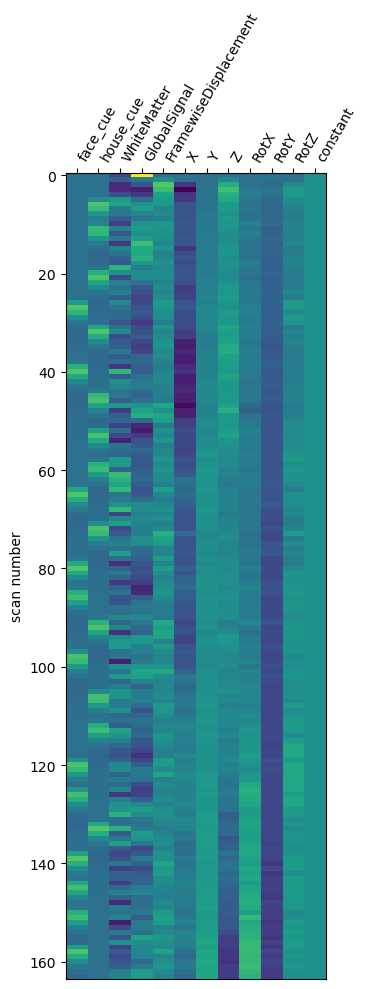

In [25]:
# Obtain and plot design matrix
design_matrix_cue = fmri_glm_cue.design_matrices_[0]
plot_design_matrix(design_matrix_cue)
plt.show()

### Plot Design matrix 'fmri_glm_probe'

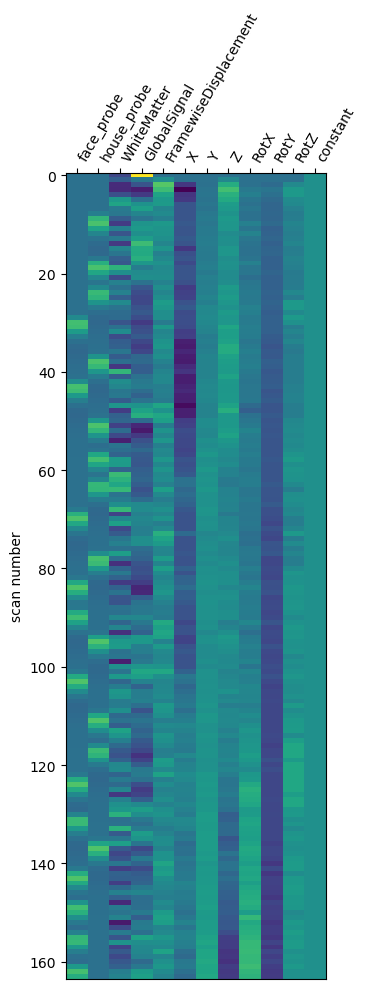

In [26]:
# Obtain and plot design matrix
design_matrix_probe = fmri_glm_probe.design_matrices_[0]
plot_design_matrix(design_matrix_probe)
plt.show()

### Plot Design matrix 'fmri_glm_vs_c1'

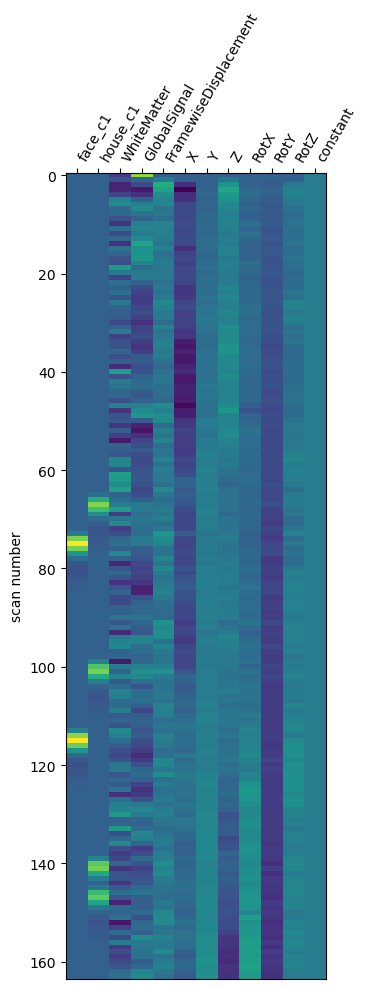

In [28]:
# Obtain and plot design matrix
design_matrix_vs_c1 = fmri_glm_vs_c1.design_matrices_[0]
plot_design_matrix(design_matrix_vs_c1)
plt.show()

### Plot Design matrix 'fmri_glm_vs_c2'

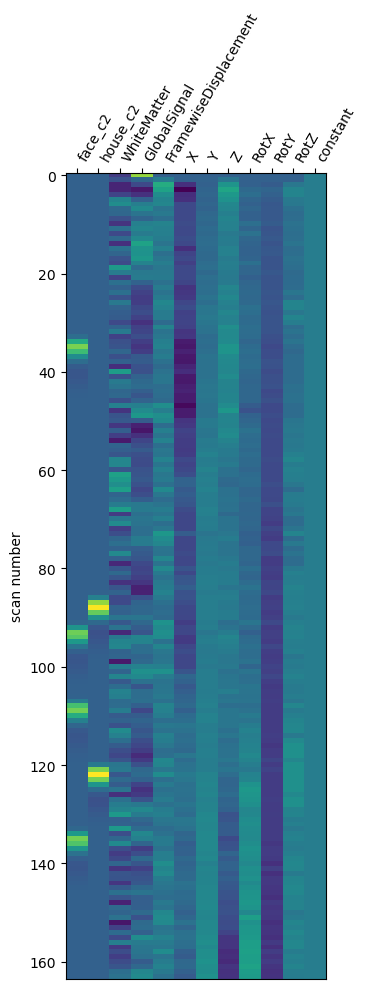

In [29]:
# Obtain and plot design matrix
design_matrix_vs_c2 = fmri_glm_vs_c2.design_matrices_[0]
plot_design_matrix(design_matrix_vs_c2)
plt.show()

### Plot Design matrix 'fmri_glm_vs_c3'

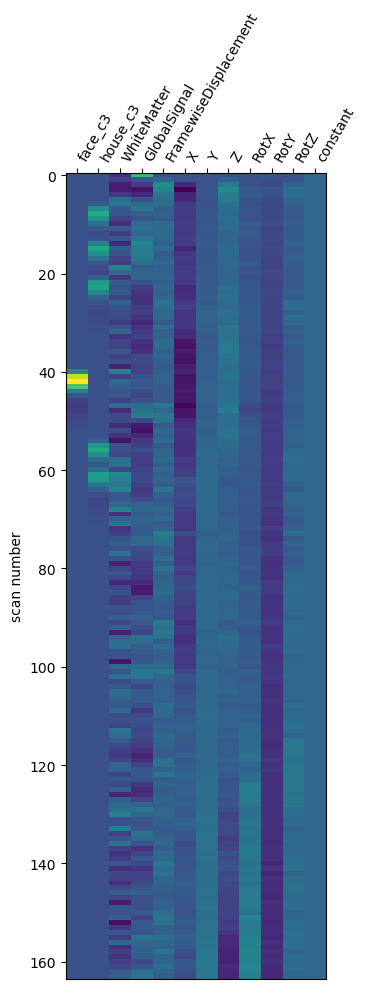

In [30]:
# Obtain and plot design matrix
design_matrix_vs_c3 = fmri_glm_vs_c3.design_matrices_[0]
plot_design_matrix(design_matrix_vs_c3)
plt.show()

### Plot Design matrix 'fmri_glm_vs_c4'

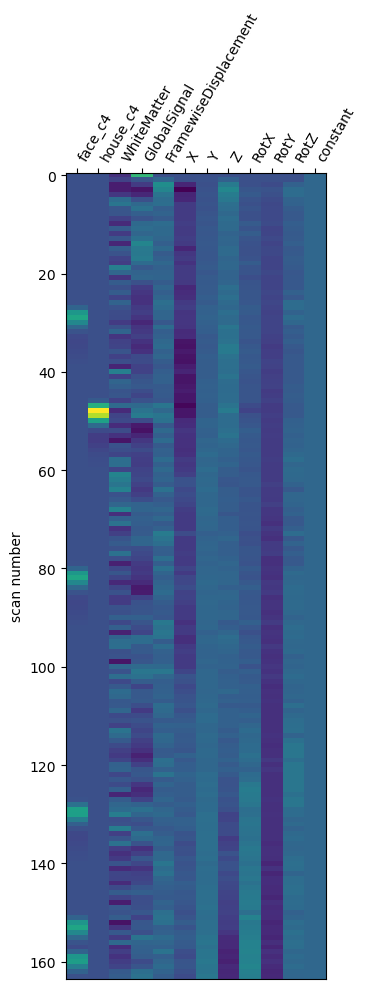

In [31]:
# Obtain and plot design matrix
design_matrix_vs_c4 = fmri_glm_vs_c4.design_matrices_[0]
plot_design_matrix(design_matrix_vs_c4)
plt.show()

## Plotting signals for each event (only showing signals from 1st fmri run)

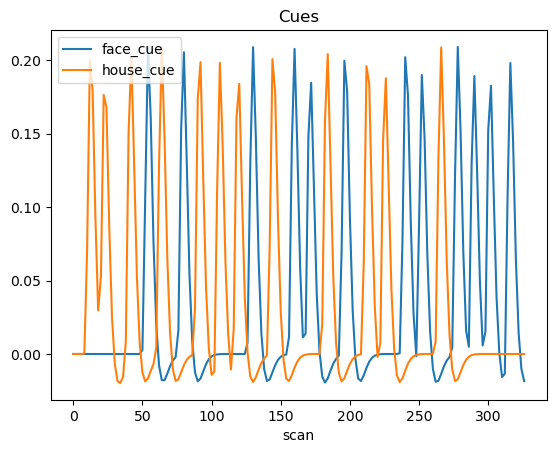

In [32]:
# Plot signals 
plt.plot(design_matrix_cue['face_cue'], label='face_cue')
plt.plot(design_matrix_cue['house_cue'], label='house_cue')
plt.xlabel('scan')
plt.title('Cues')
plt.legend(loc='upper left')
plt.show()


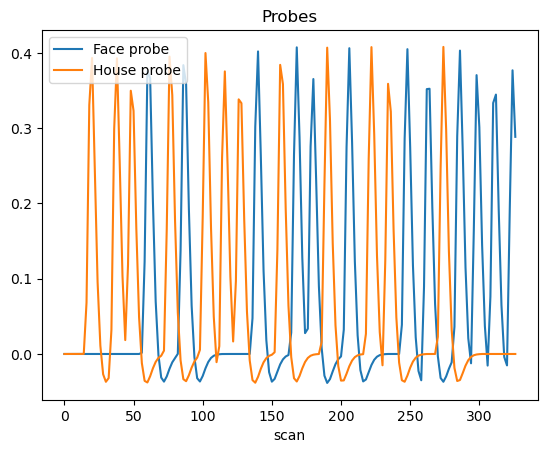

In [33]:
plt.plot(design_matrix_probe['face_probe'], label='Face probe')
plt.plot(design_matrix_probe['house_probe'], label='House probe')
plt.xlabel('scan')
plt.title('Probes')
plt.legend(loc='upper left')
plt.show()

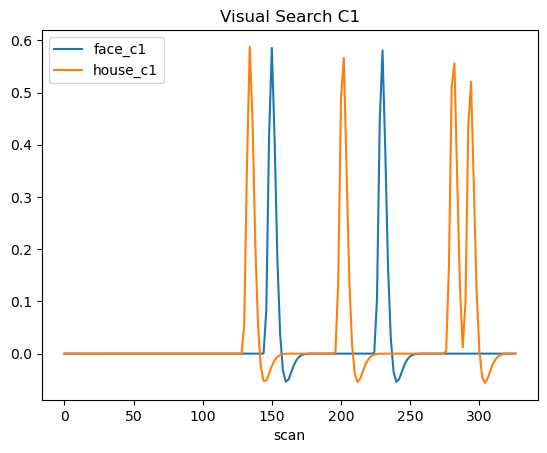

In [34]:
plt.plot(design_matrix_vs_c1['face_c1'], label='face_c1')
plt.plot(design_matrix_vs_c1['house_c1'], label='house_c1')
plt.xlabel('scan')
plt.title('Visual Search C1')
plt.legend(loc='upper left')
plt.show()

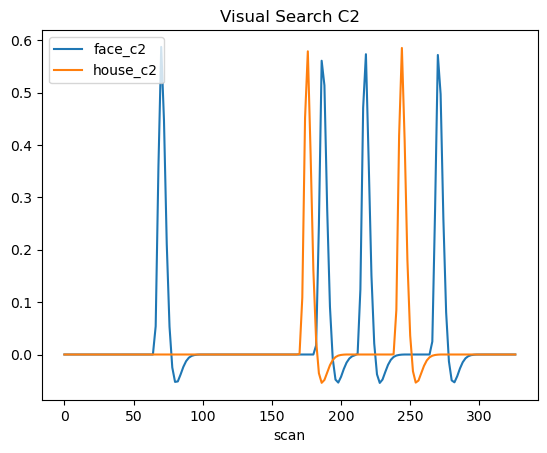

In [35]:
plt.plot(design_matrix_vs_c2['face_c2'], label='face_c2')
plt.plot(design_matrix_vs_c2['house_c2'], label='house_c2')
plt.xlabel('scan')
plt.title('Visual Search C2')
plt.legend(loc='upper left')
plt.show()

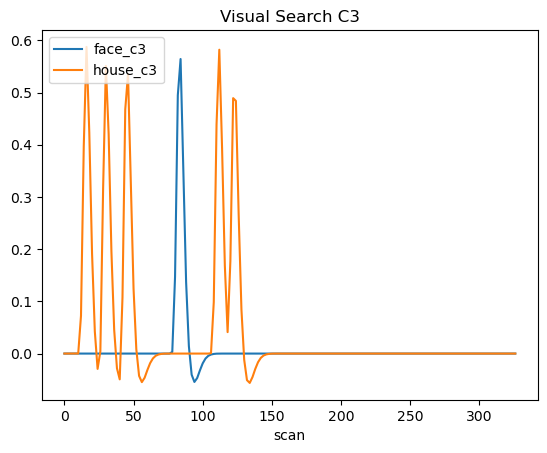

In [36]:
plt.plot(design_matrix_vs_c3['face_c3'], label='face_c3')
plt.plot(design_matrix_vs_c3['house_c3'], label='house_c3')
plt.xlabel('scan')
plt.title('Visual Search C3')
plt.legend(loc='upper left')
plt.show()

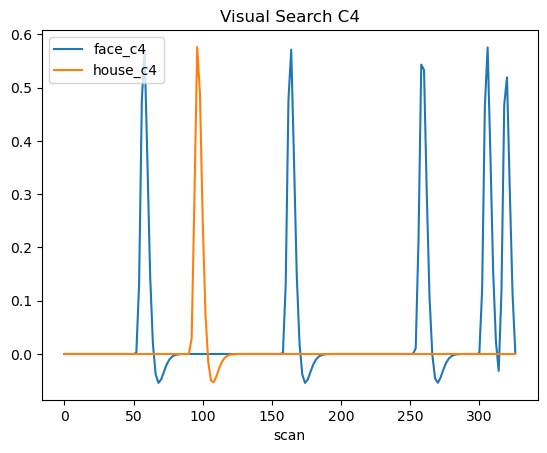

In [37]:
plt.plot(design_matrix_vs_c4['face_c4'], label='face_c4')
plt.plot(design_matrix_vs_c4['house_c4'], label='house_c4')
plt.xlabel('scan')
plt.title('Visual Search C4')
plt.legend(loc='upper left')
plt.show()

## Ploting contrasts

In [38]:
def plot_contrast(contrast, title):
    
    # Get raw contrast activation
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')
    
    # Get clean contrast and threshold to visualize results
    # Threshold: false discovery rate 5% w/ cluster > 8 voxels
    clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)
    s_threshold = str(round(threshold, 1))
    
    # Plot contrast
    dim = ['x', 'y', 'z']
    for x in range(3):
    
        plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('' + title + ' (Z>' + s_threshold + '), fdr = .05')) 

### Face cue 

In [39]:
# Get raw contrast activation
z_map = fmri_glm_cue.compute_contrast('+1*face_cue -1*house_cue', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') #, cluster_threshold=5
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:652: UserWarning: One contrast given, assuming it for all 8 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


FDR(0.05) threshold: 3.4


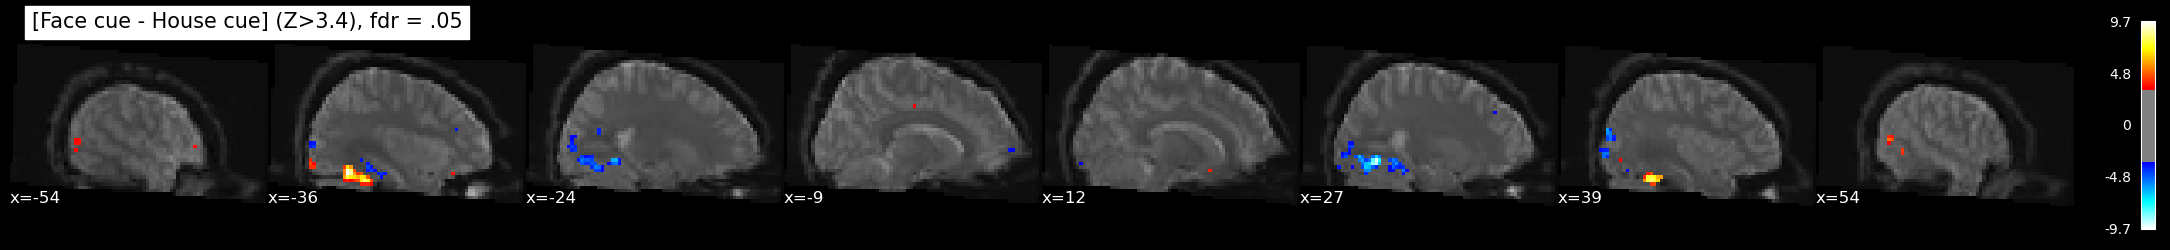

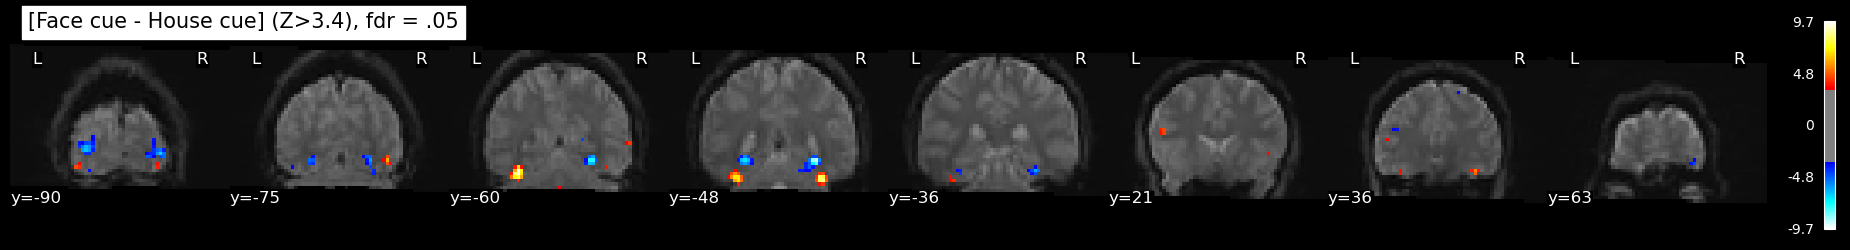

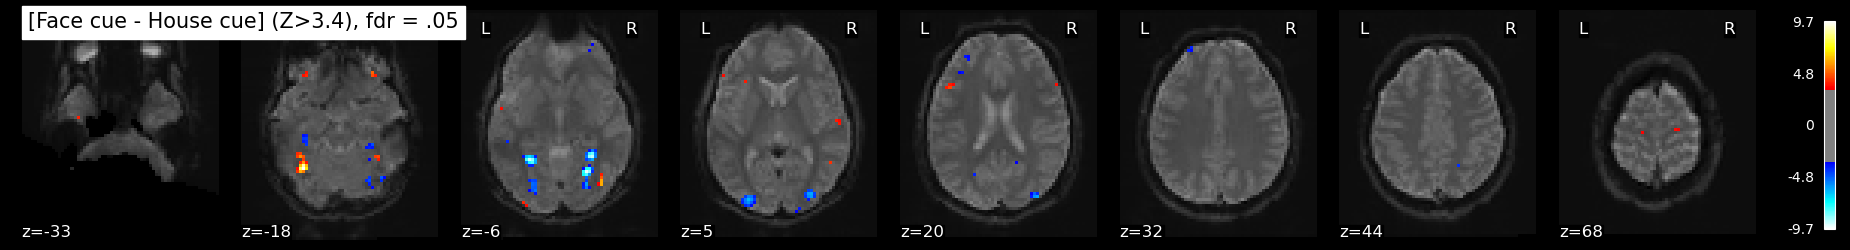

In [40]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face cue - House cue] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### House cue

In [41]:
# Get raw contrast activation
z_map = fmri_glm_cue.compute_contrast('+1*house_cue -1*face_cue', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.4


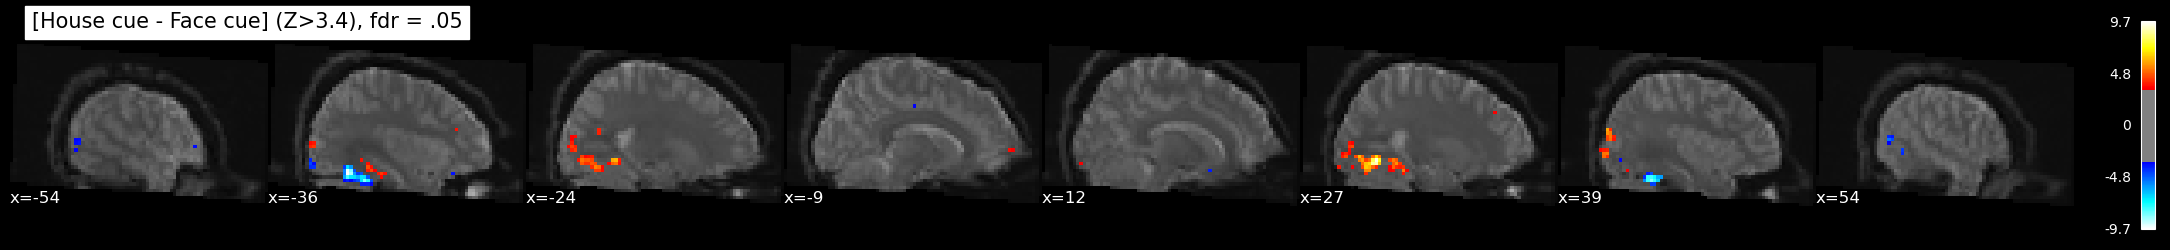

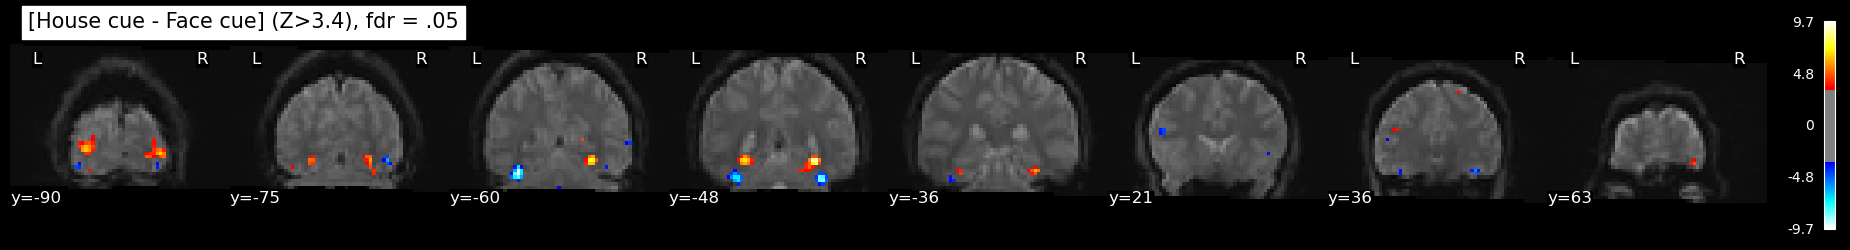

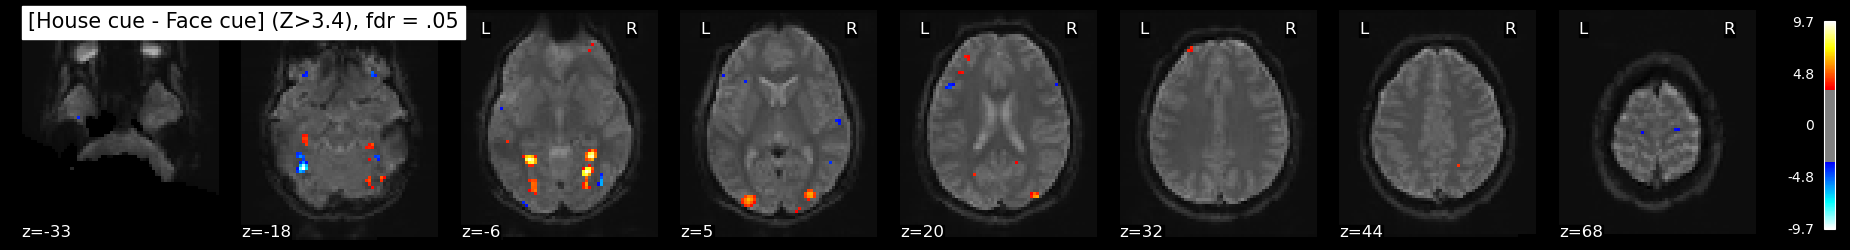

In [42]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House cue - Face cue] (Z>' + s_threshold + '), fdr = .05'))
    plt.show()

### Face probe

In [43]:
"""
"""
# Get raw contrast activation
z_map = fmri_glm_probe.compute_contrast('+1*face_probe -1*house_probe', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: inf


/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


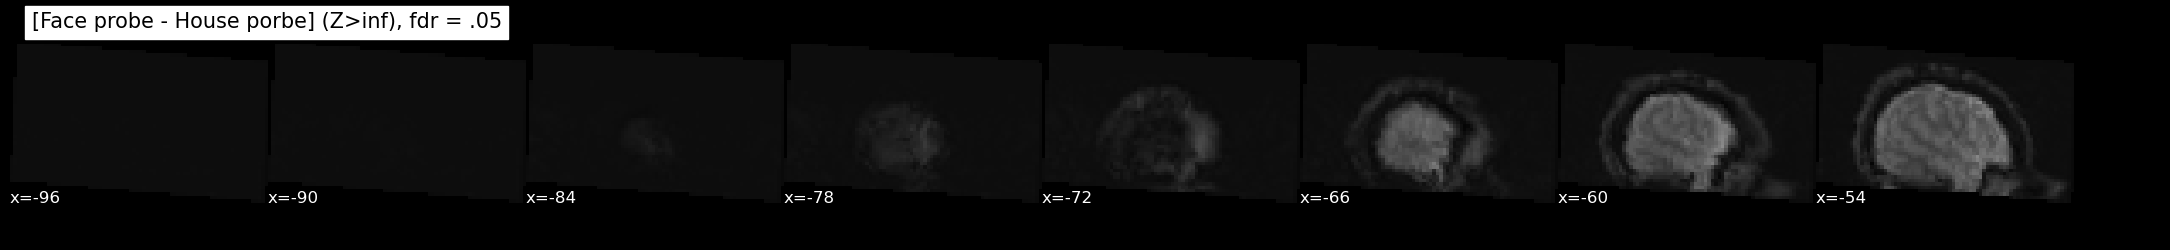

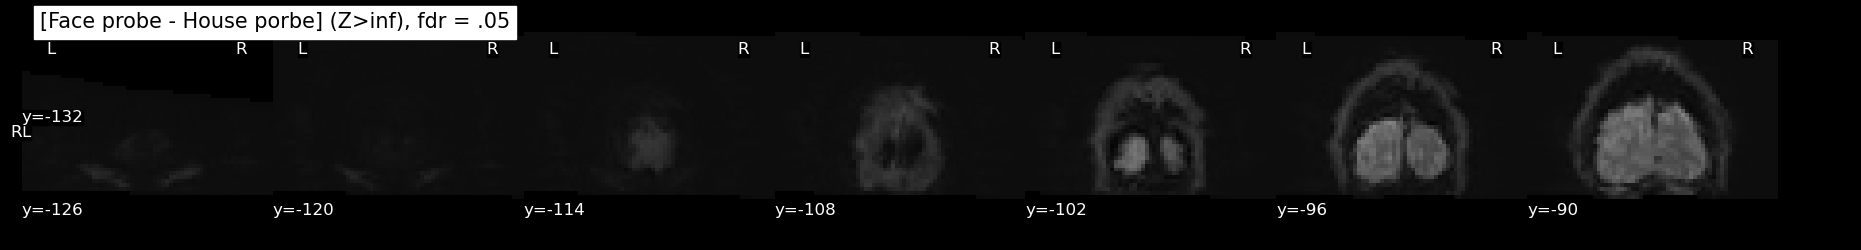

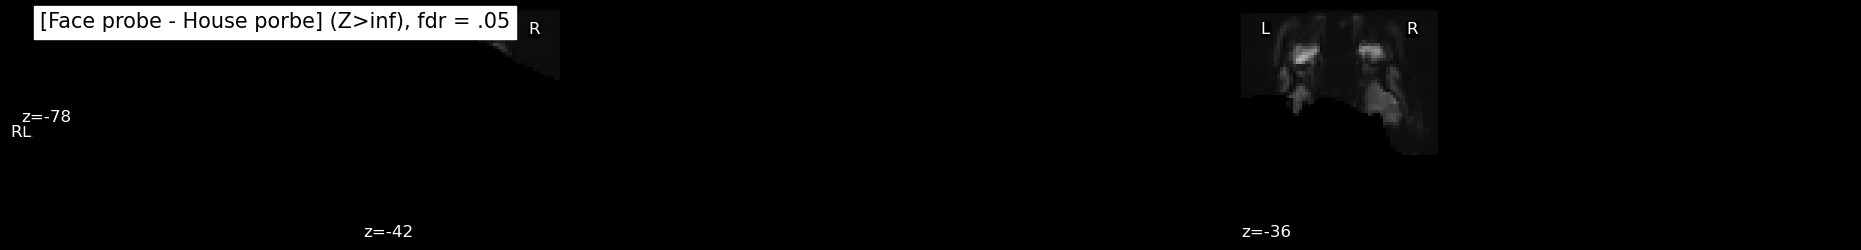

In [44]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face probe - House porbe] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### House probe

In [45]:
"""
"""
# Get raw contrast activation
z_map = fmri_glm_probe.compute_contrast('+1*house_probe -1*face_probe', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: inf


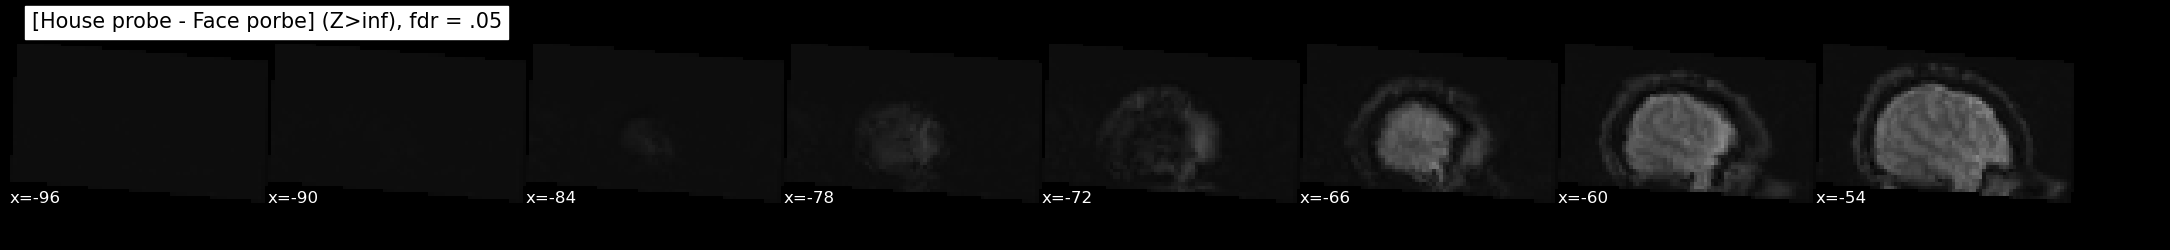

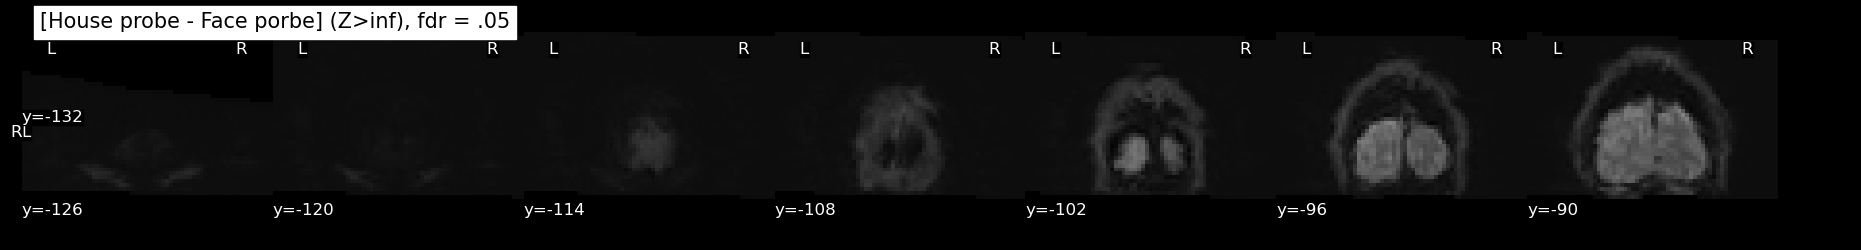

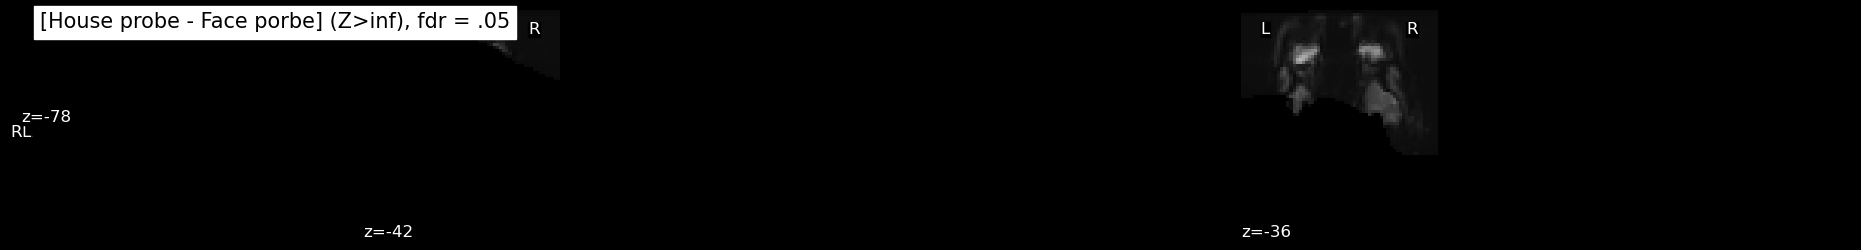

In [46]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House probe - Face porbe] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### C1 (low interference, easy search): Visual search and probe

In [47]:
# Get raw contrast activation
z_map = fmri_glm_vs_c1.compute_contrast('+1*face_c1 -1*house_c1', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:652: UserWarning: One contrast given, assuming it for all 7 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


FDR(0.05) threshold: inf


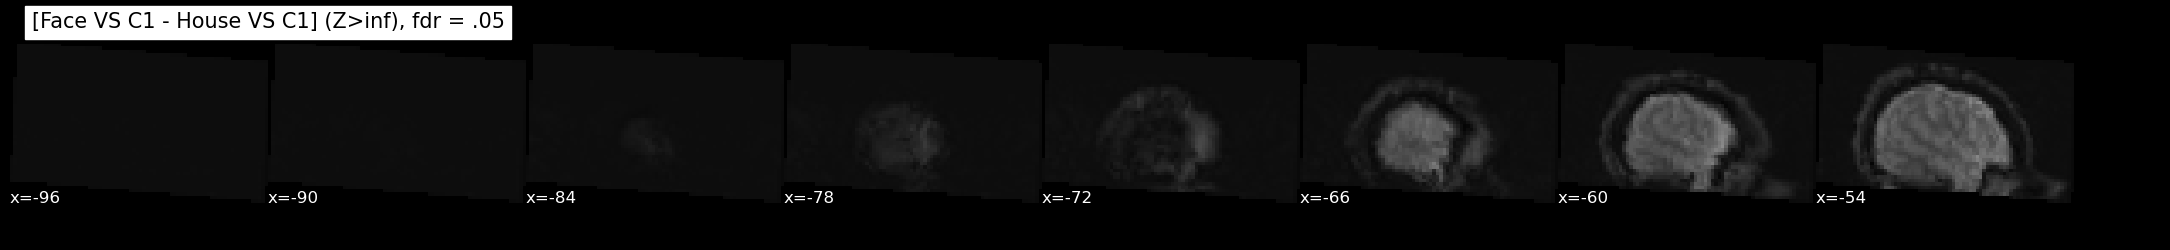

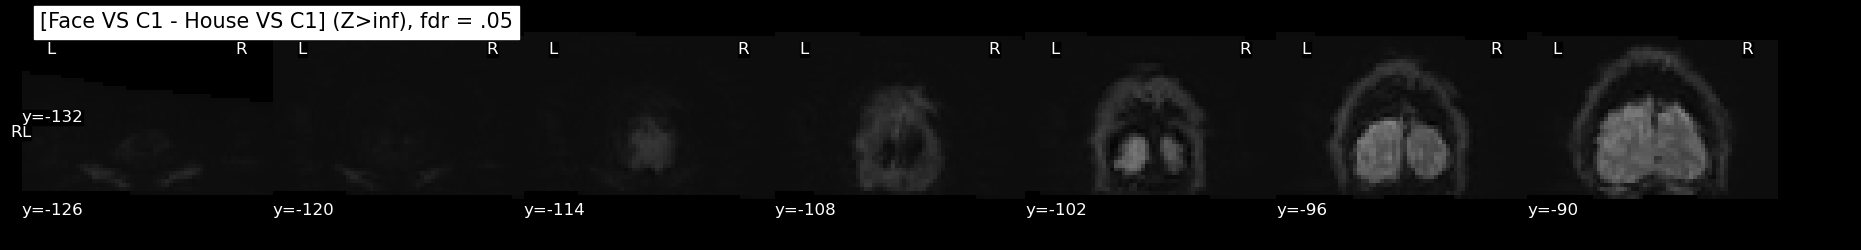

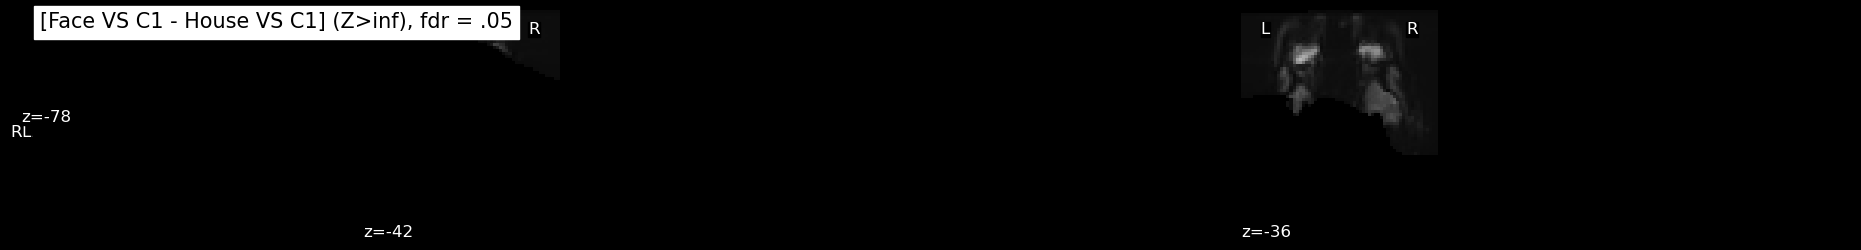

In [48]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face VS C1 - House VS C1] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

In [49]:
# Get raw contrast activation
z_map = fmri_glm_vs_c1.compute_contrast('+1*house_c1 -1*face_c1', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: inf


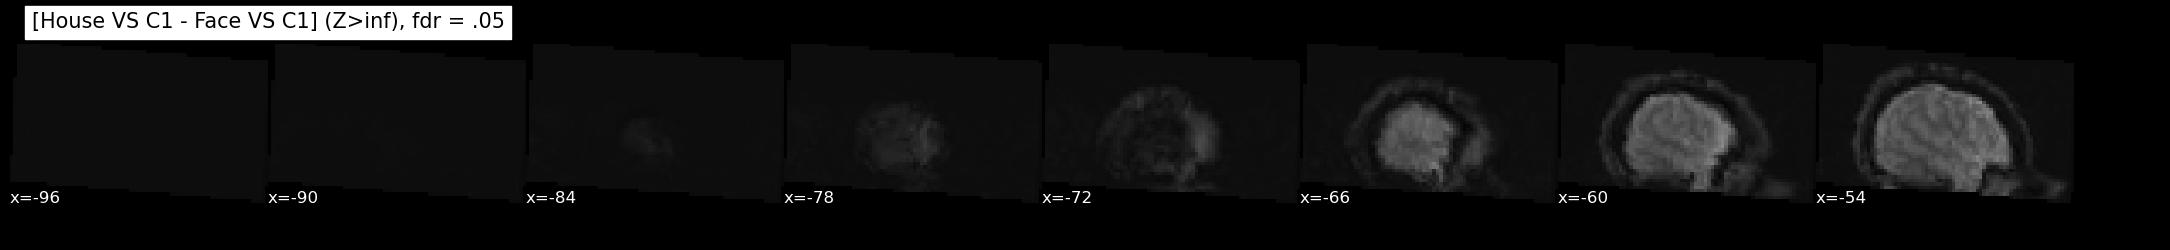

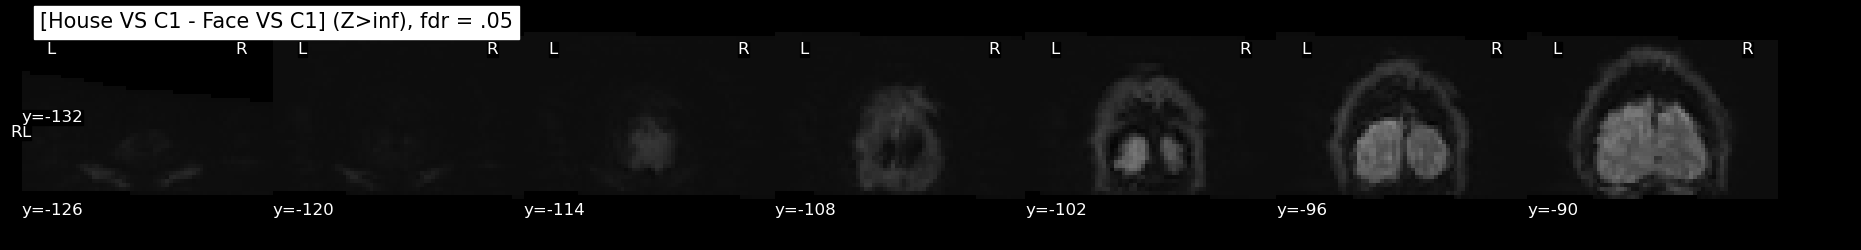

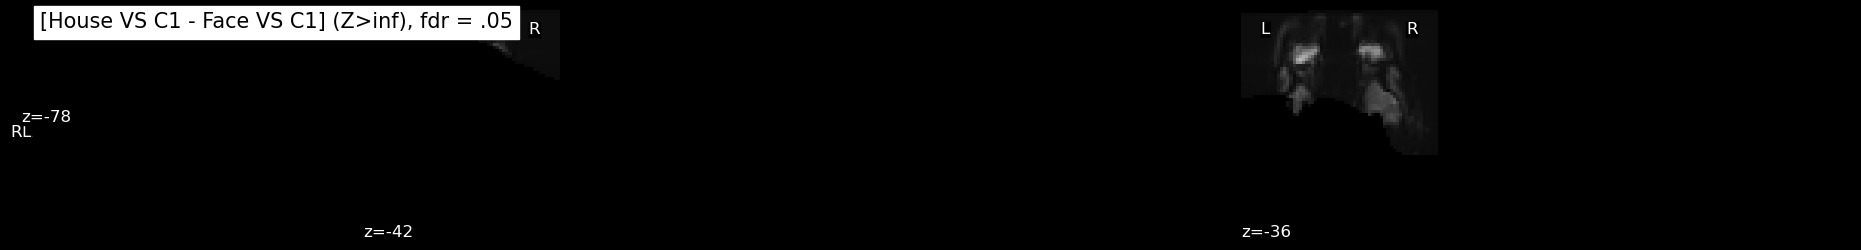

In [50]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House VS C1 - Face VS C1] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### C2 (low interference, hard search): Visual search and probe

In [51]:
# Get raw contrast activation
z_map = fmri_glm_vs_c2.compute_contrast('+1*face_c2 -1*house_c2', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.5, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: inf


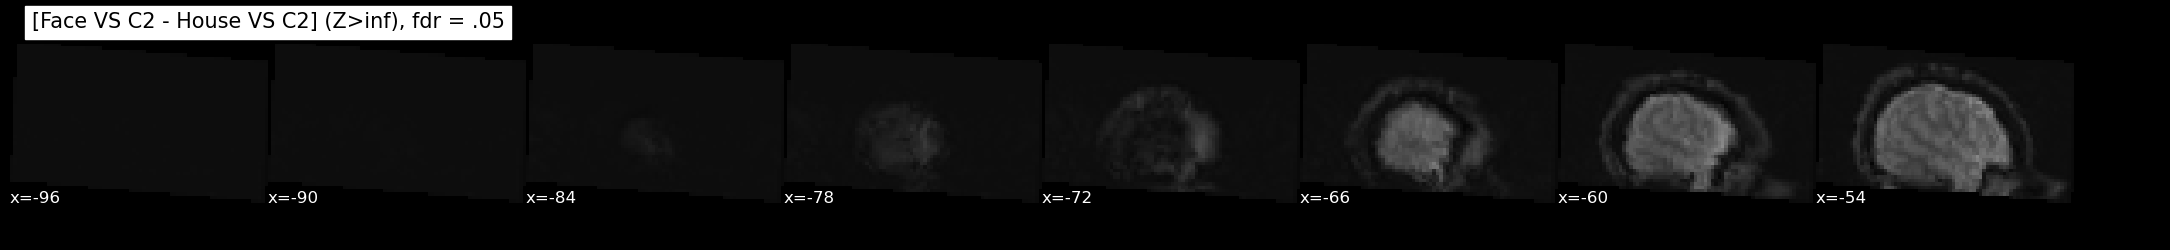

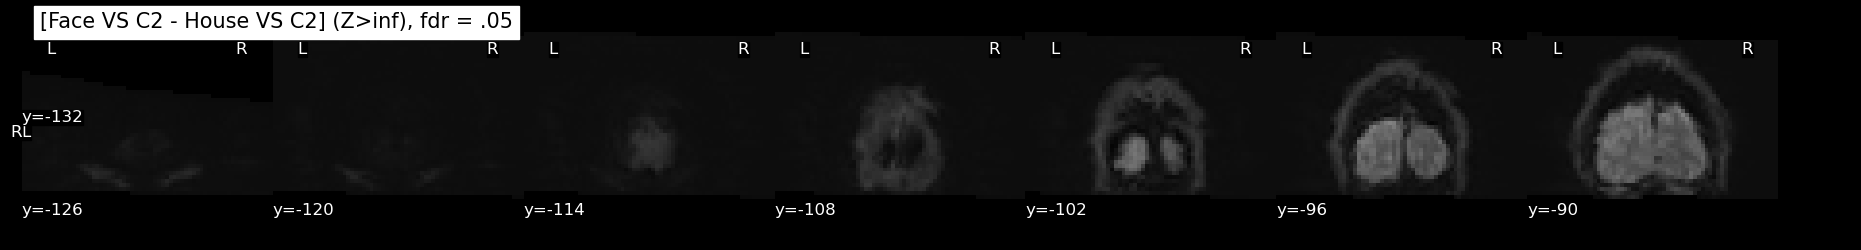

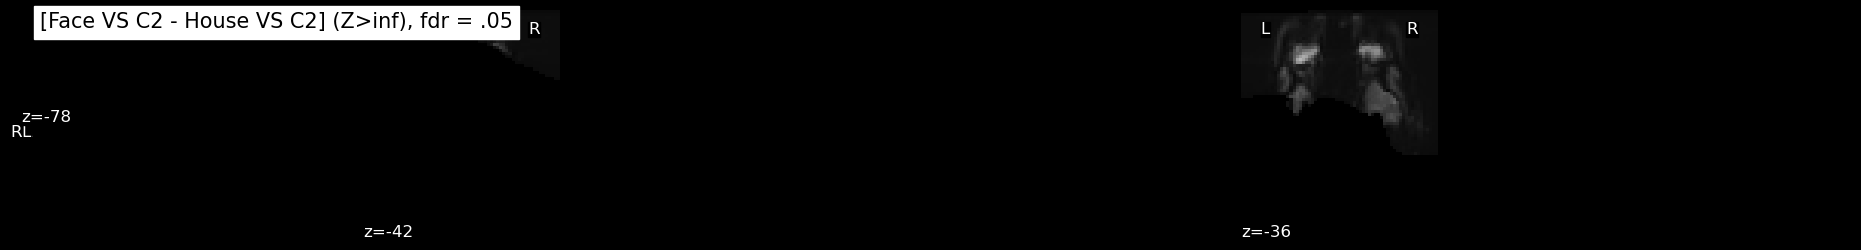

In [52]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face VS C2 - House VS C2] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

In [53]:
# Get raw contrast activation
z_map = fmri_glm_vs_c2.compute_contrast('+2*house_c2 -2*face_c2', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: inf


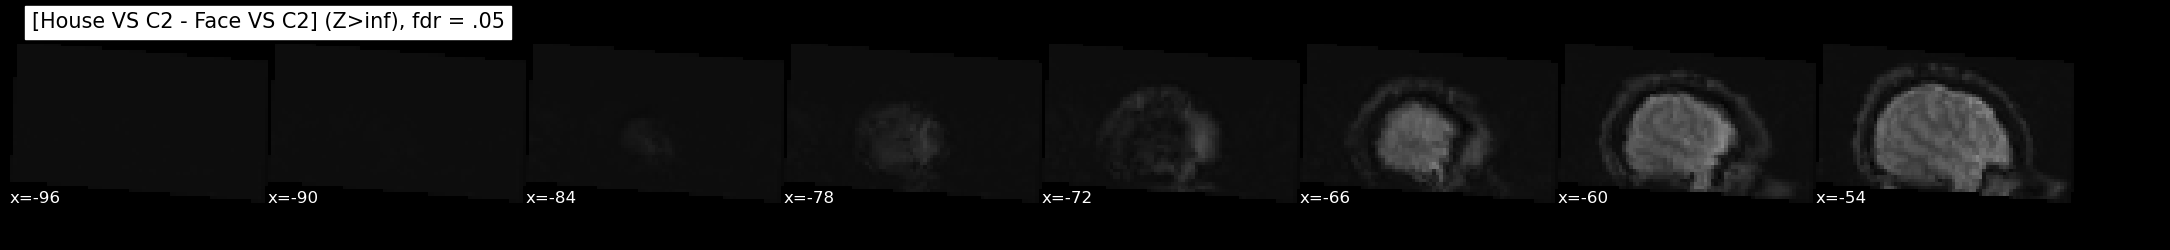

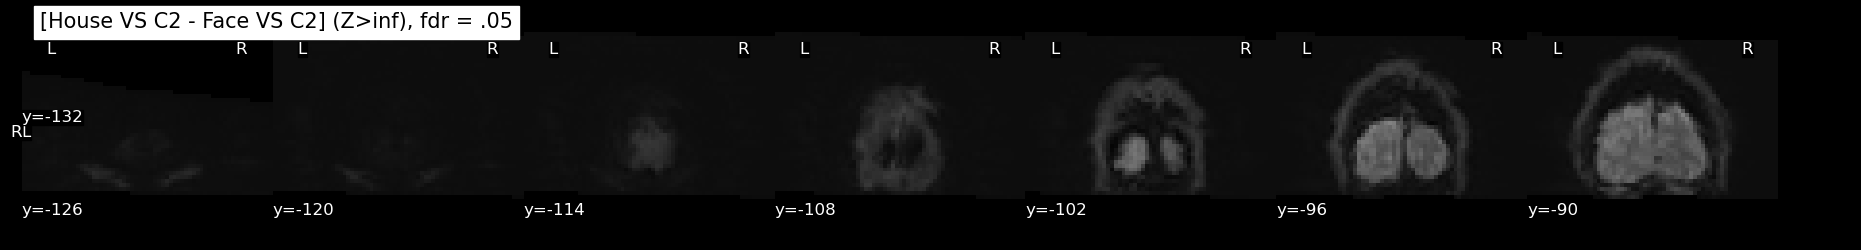

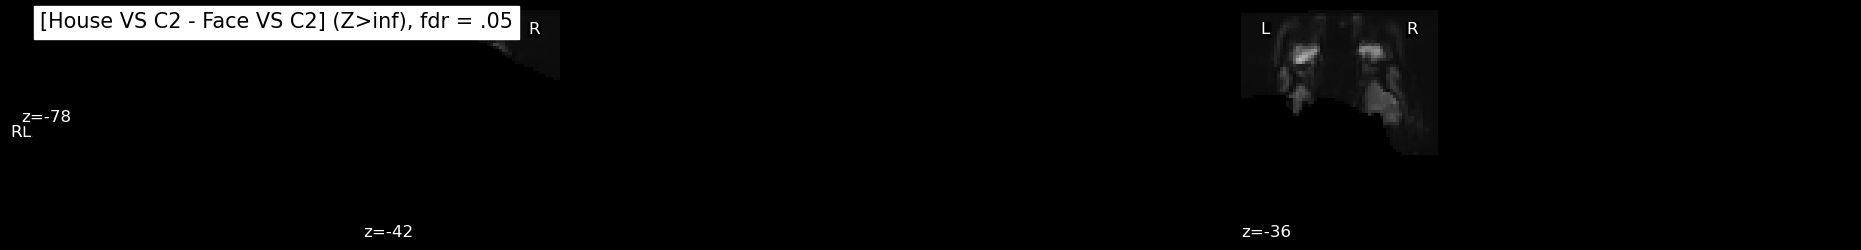

In [54]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House VS C2 - Face VS C2] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### C3 (high interference, easy search): Visual search and probe

In [67]:
# Get raw contrast activation
z_map = fmri_glm_vs_c3.compute_contrast('+1*face_c3 -1*house_c3', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.7


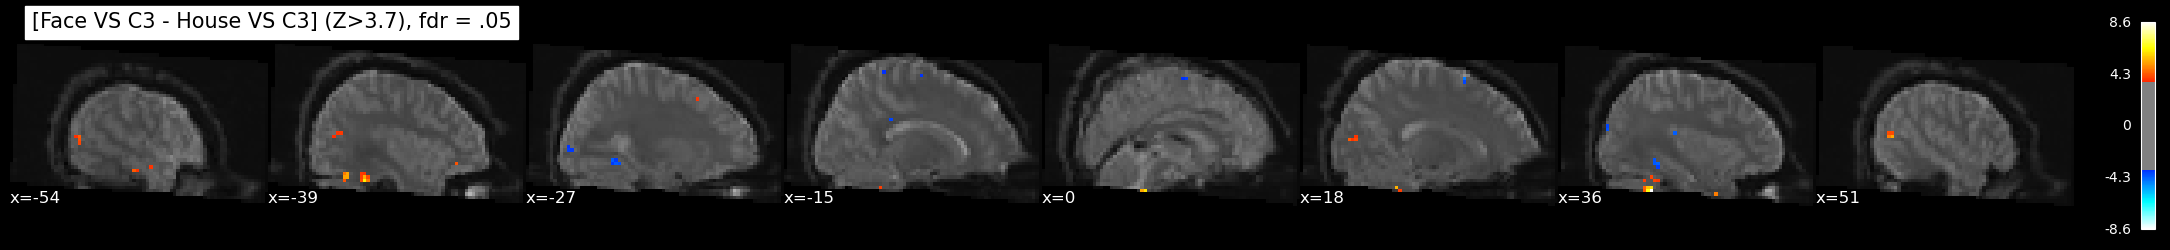

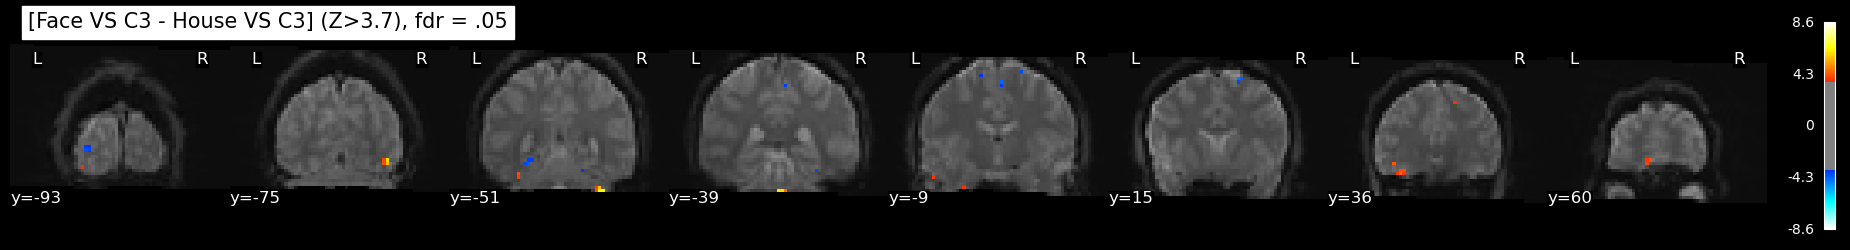

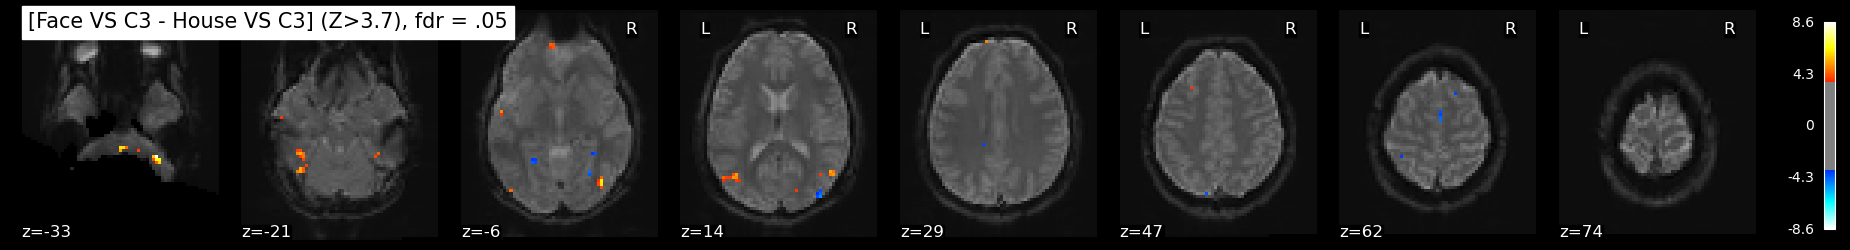

In [68]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face VS C3 - House VS C3] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

In [69]:
# Get raw contrast activation
z_map = fmri_glm_vs_c3.compute_contrast('+1*house_c3 -1*face_c3', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.7


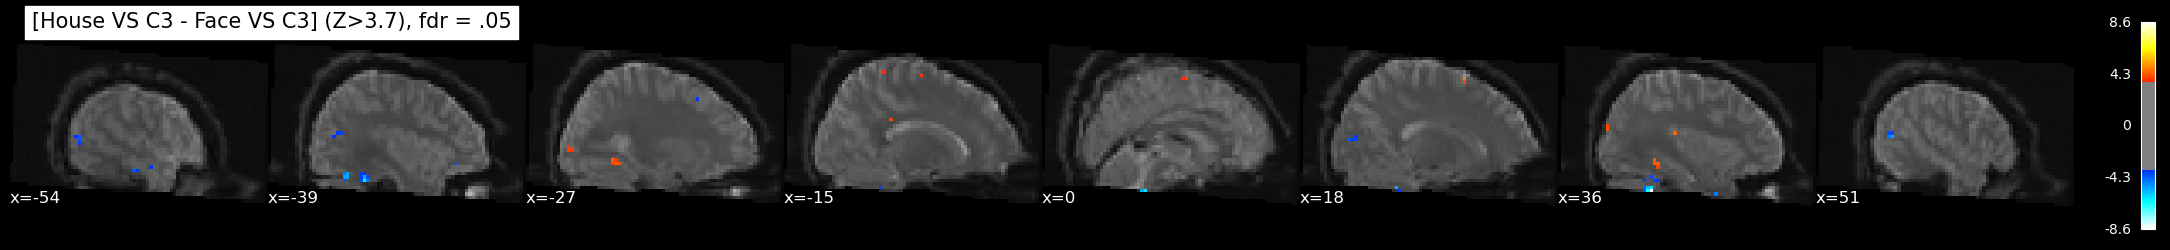

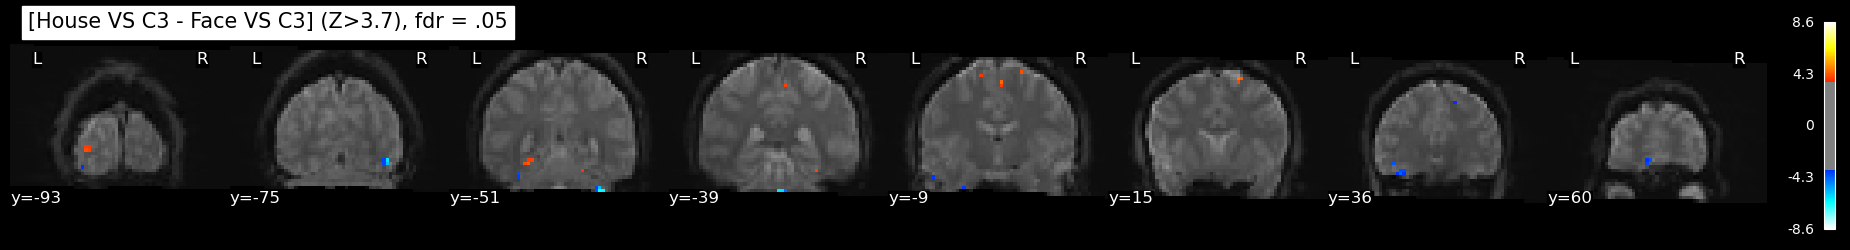

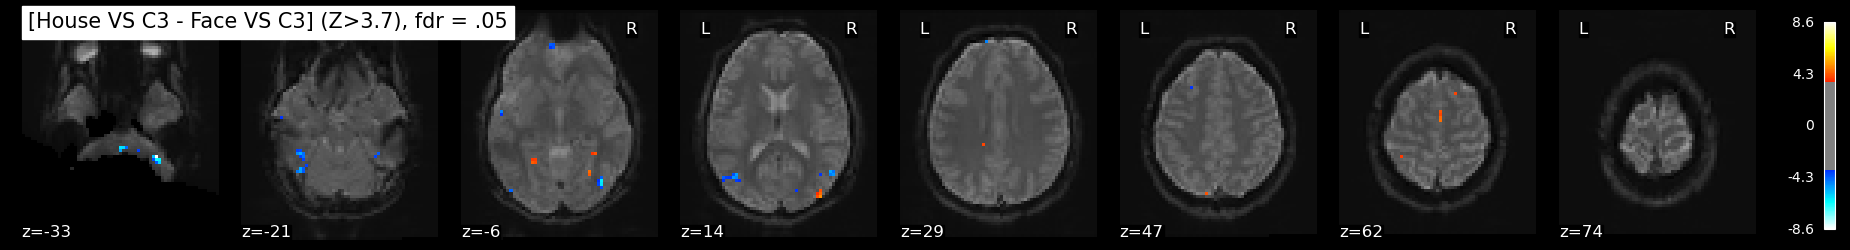

In [70]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House VS C3 - Face VS C3] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### C4 (high interference, hard search): Visual search and probe

In [65]:
# Get raw contrast activation
z_map = fmri_glm_vs_c4.compute_contrast('+1*face_c4 -1*house_c4', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.6


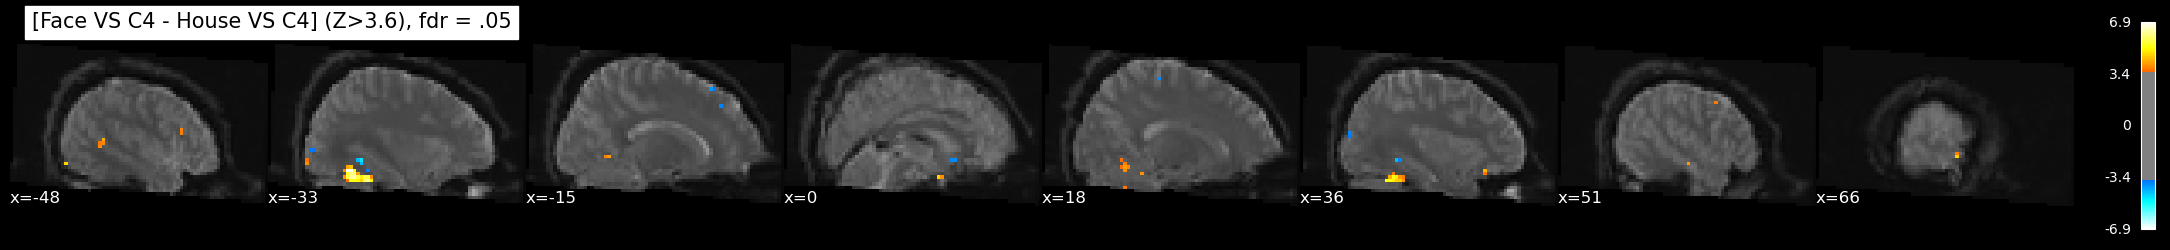

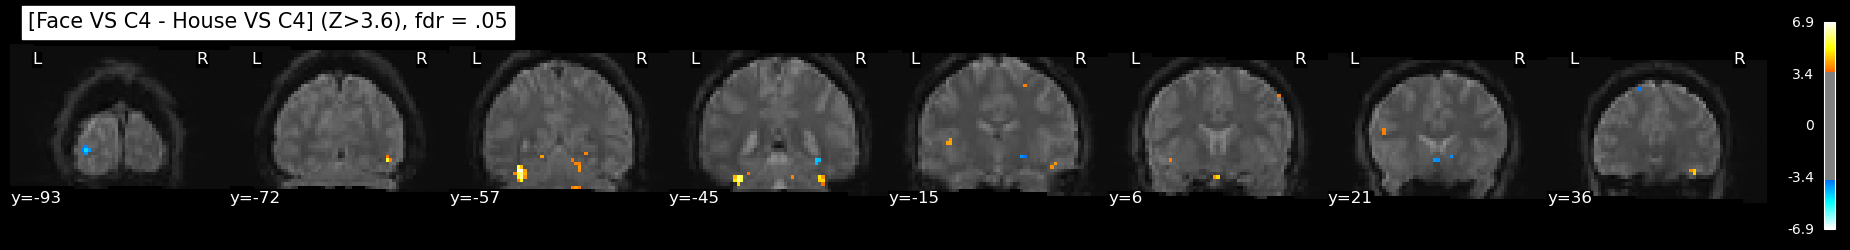

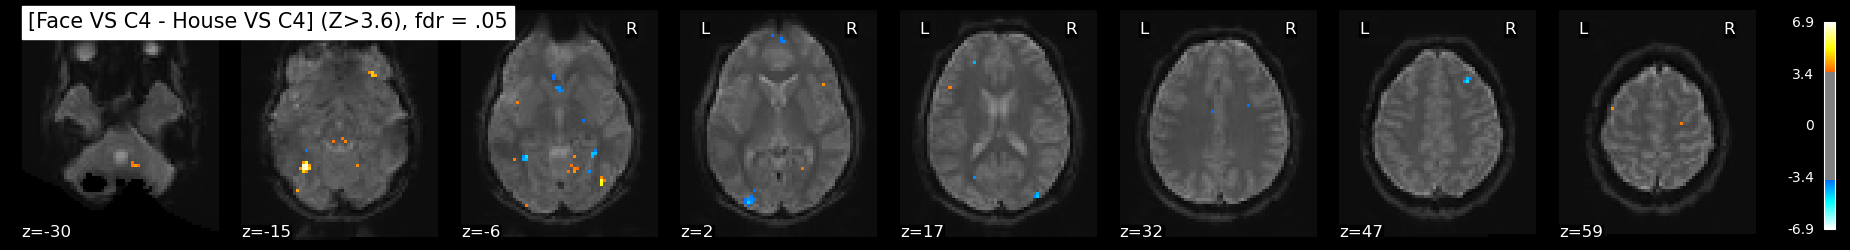

In [66]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face VS C4 - House VS C4] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

In [63]:
# Get raw contrast activation
z_map = fmri_glm_vs_c4.compute_contrast('+1*house_c4 -1*face_c4', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.6


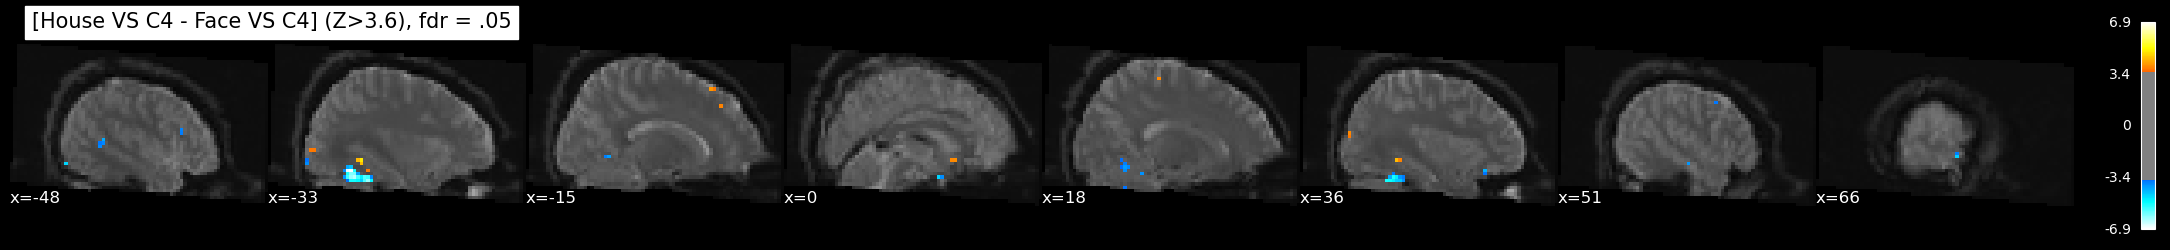

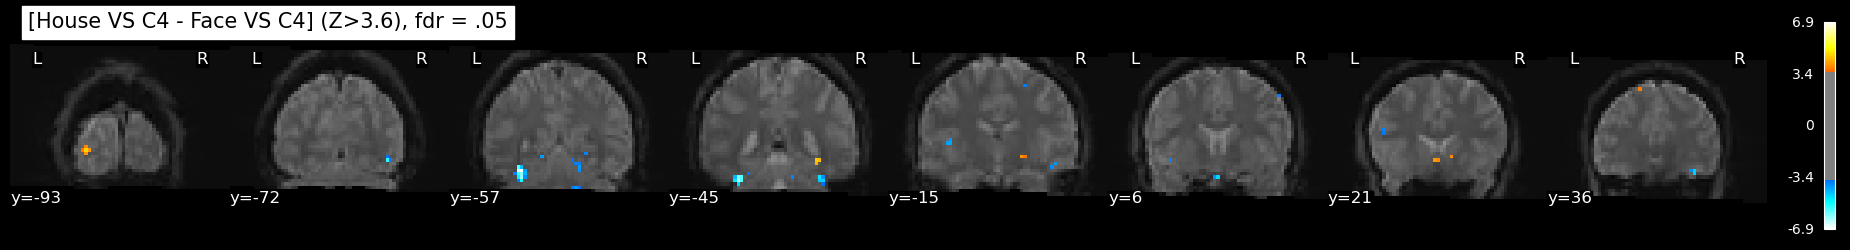

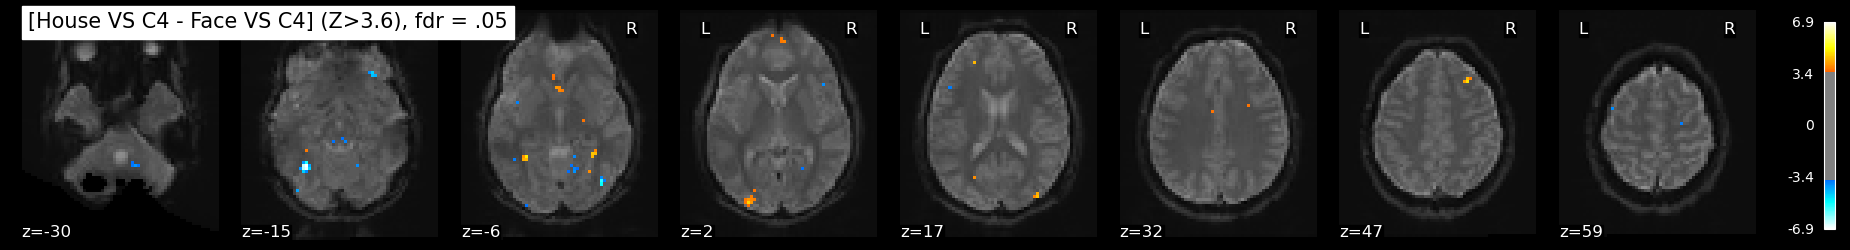

In [64]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House VS C4 - Face VS C4] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

# ....

In [ ]:
"""
from nltools.stats import fdr as fdr
# Get raw contrast activation
z_map = fmri_glm.compute_contrast('+house_probe -face_probe', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% w/ cluster > 8 voxels

#clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
#print(threshold)
#s_threshold = str(round(threshold, 1))
print(z_map.shape)
print(type(z_map))
np_z_map = np.array(z_map)
clean_map = fdr(p=np_z_map, q=0.05)
"""

In [ ]:
"""
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(z_map, bg_img=mean_img, threshold=2.5,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House cue - Face cue] (Z>' + s_threshold + '), fdr = .05'))
    plt.show()

"""


In [ ]:
"""
plot_contrast('+house_probe -face_probe', '[House probe - Face probe]')
plt.show()
"""

In [ ]:
#contrast_matrix = np.eye(design_matrix.shape[1])
#basic_contrasts = dict([(column, contrast_matrix[i])
 #                       for i, column in enumerate(design_matrix.columns)])
#basic_contrasts.keys()
#basic_contrasts['face_cue'].shape